# **Car Acceptability Dataset Overview**

Greetings everyone,

In this project, we will perform multi-class classification prediction based on the features present in the given dataset. Below are some key details about the dataset that will be used for this prediction:

The dataset contains approximately 1800 rows.
There are a total of 7 columns in the dataset.
The target variable in the dataset is labeled as "class".
Here is a brief description of each column in the dataset:

**Buying**

Description: Buying price of the car, categorized into different levels of affordability.

Examples: low, med, high

**Maint**

Description: Price of the maintenance of the car, categorized into different levels of affordability.

Examples: low, med, high

**Doors**

Description: Number of doors in the car.

Examples: 2, 3, 4

**Persons**

Description: Capacity in terms of persons the car can carry.

Examples: 2, 4, more

**Lug_boot**

Description: The size of the luggage boot in the car.

Examples: small, med, big

**Safety**

Description: Estimated safety level of the car.

Examples: low, med, high

**Class**

Description: Car acceptability, categorized into different levels.

Examples: unacc (unacceptable), acc (acceptable), good, v-good (very good)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

In [3]:
path = "/kaggle/input/car-dataset/car_acceptability.txt"
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(path, header=None, names=column_names)
df = df.astype(str)
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,?,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,?,unacc


# **Summary of Data Quality Checks**

**Shape**: The dataset consists of a total of {{num_rows}} rows and {{num_columns}} columns.

**Info**: The dataset information provides details about the data types, non-null counts, and memory usage.

**Types**: Data types of each column are displayed to understand the nature of the data.

**Missing Values**: The count of missing values in each column is shown. There are no missing values in the dataset.

**Duplicated Values**: The number of duplicated rows in the dataset is presented. There are no duplicated rows.

**Unique Values**: The count of unique values in each column is displayed, which gives an idea of the cardinality of categorical features.

**Describe**: Descriptive statistics including mean, standard deviation, minimum, 5th percentile, 25th percentile (Q1), median (50th percentile), 75th percentile (Q3), and 95th percentile are shown for numerical columns.

In [4]:
def check_df(data, head=5):
    print("\n******Shape******")
    print(f'Shape     : {df.shape}\n')
    print("\n******Info******")
    print(data.info())
    print("\n******Types******")
    print(data.dtypes)
    print("\n******Missing Values******")
    print(data.isnull().sum())
    print("\n******Duplicated Values******")
    print(data.duplicated().sum())
    print("\n******Unique Values******")
    print(data.nunique())
    print("\n******Describe******")
    print(data.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T)
    
check_df(df)


******Shape******
Shape     : (1729, 7)


******Info******
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1729 entries, 0 to 1728
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1729 non-null   object
 1   maint     1729 non-null   object
 2   doors     1729 non-null   object
 3   persons   1729 non-null   object
 4   lug_boot  1729 non-null   object
 5   safety    1729 non-null   object
 6   class     1729 non-null   object
dtypes: object(7)
memory usage: 94.7+ KB
None

******Types******
buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

******Missing Values******
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

******Duplicated Values******
0

******Unique Values******
buying      8
maint       5
doors       9
persons     4
lug_boot    4
safety     

# **Summary of Unexpected Value Check**

The function iterates through each categorical column in the dataset. It checks for values that contain certain special characters such as **!, ?, @,** and others. These unexpected values might indicate data entry errors or anomalies.

In [5]:
def unexcepted_value(dataframe):
    for col in dataframe.columns:
        if dataframe[col].dtype in ['object','category']:
            filtered_values = [value for value in dataframe[col] if pd.notnull(value) and \
                                any(char in value for char in ['!', '?', '@', '#', '$', '%', '&', '*', '_', '+', '-', '=', '|', 
                                                                  ':', ';', '<', '>', ',', '.', '(', ')', '[', ']', '{', '}'])]
            filtered_values.sort()
            print(col, "=" ,filtered_values)

unexcepted_value(df)

buying = ['-', '?', '?', '?']
maint = ['?', '?', '?', '?']
doors = ['-', '5+', '?', '?', '?']
persons = ['?', '?', '?']
lug_boot = ['?', '?']
safety = ['*', '-', '-', '?', '?']
class = ['?', '?']


# **Summary of Special Character Replacement and Unexpected Value Check**

The replace_special_chars function uses regular expressions to remove certain special characters from the categorical columns in the dataset.

For each column, the function iterates through the DataFrame, applies the special character replacement, and then replaces any empty values with **NaN** using **np.nan**.

The unexcepted_value function is then used again to check for any remaining unexpected values in the dataset after the special character replacement.

The function outputs the results for each categorical column.

**Buying**: No unexpected values found.

**Maint**: No unexpected values found.

**Doors**: No unexpected values found.

**Persons**: No unexpected values found.

**Lug_boot**: No unexpected values found.

**Safety**: No unexpected values found.

**Class**: No unexpected values found.

In [6]:
def replace_special_chars(text):
    return re.sub(r'[?!@#$%&*_+\-=|:";<>,./()[\]{}\']', '', text)

for col in df.columns:
    df[col] = df[col].apply(replace_special_chars)
    df[col] = df[col].replace('', np.nan)
    
unexcepted_value(df)

buying = []
maint = []
doors = []
persons = []
lug_boot = []
safety = []
class = []


# **Summary of Value Replacement**

In the 'buying' column, the value "düsük" was replaced with "low" to achieve consistency in labeling.

Additionally, any occurrences of "**nan**" were replaced with NaN using np.nan.
In the 'doors' column, the values "iki", "44", and "5" were replaced with "2", "4", and "5more", respectively, for clarity and uniformity.

In the 'safety' column, any occurrences of "nan" were replaced with NaN using np.nan.

These value replacements contribute to a **cleaner and more standardized dataset**, which is crucial for accurate analysis and modeling.

In [7]:
df["buying"] = df.buying.replace("düsük", "low")
df["buying"] = df.buying.replace("nan", np.nan)
df["doors"] = df.doors.replace("iki", "2")
df["doors"] = df.doors.replace("44", "4")
df["doors"] = df.doors.replace("5", "5more")
df["safety"] = df.safety.replace("nan", np.nan)

In [8]:
for col in df.columns:
    print(df[col].value_counts(),"\n")

high     432
med      431
low      431
vhigh    430
Name: buying, dtype: int64 

high     432
med      432
low      432
vhigh    429
Name: maint, dtype: int64 

3        432
2        431
4        431
5more    431
Name: doors, dtype: int64 

4       576
more    576
2       574
Name: persons, dtype: int64 

small    576
big      576
med      575
Name: lug_boot, dtype: int64 

high    576
med     574
low     573
Name: safety, dtype: int64 

unacc    1209
acc       384
good       69
vgood      65
Name: class, dtype: int64 



# **Summary of Null Values Visualization**

The code calculates the count and percentage of null values in each column of the dataset.

The horizontal bar chart is generated using Matplotlib to visually represent the percentage of null and non-null values for each column.

Columns with missing values are shown in red, while columns with no missing values are shown in orange.

The chart is labeled with titles, axes, and legend for clear understanding.

The function autolabel adds labels to the bars to display the percentage values.

This visualization provides an insightful overview of the distribution of null values in the dataset, aiding in identifying columns with significant missing data.

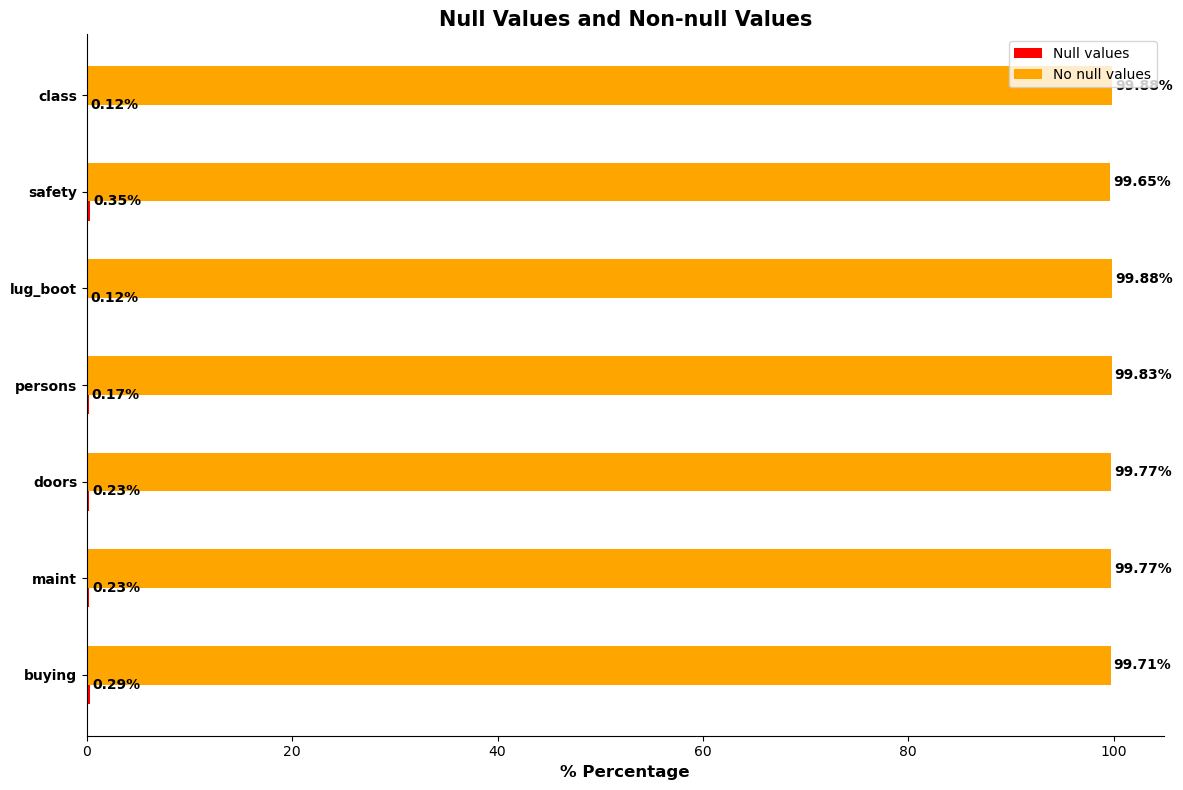

In [9]:
df_null_values = df.isnull().sum().to_frame().rename(columns={0: 'Count'})
df_null_values['Percentage_nulls'] = (df_null_values['Count'] / len(df)) * 100
df_null_values['Percentage_no_nulls'] = 100 - df_null_values['Percentage_nulls']

n = len(df_null_values.index)
x = np.arange(n)

fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.4
gap = 0.2

rects1 = ax.barh(x - gap / 2, df_null_values['Percentage_nulls'], bar_width, label='Null values', color='red')
rects2 = ax.barh(x + gap / 2, df_null_values['Percentage_no_nulls'], bar_width, label='No null values', color='orange')

ax.set_title('Null Values and Non-null Values', fontsize=15, fontweight='bold')
ax.set_xlabel('% Percentage', fontsize=12, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(df_null_values.index, fontsize=10, fontweight='bold') 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate(f'{width:.2f}%',
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(2, 0),
                    textcoords="offset points",
                    ha='left', va='center', size=10, weight='bold')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

# **Summary of Column Categorization**

The function categorizes columns in the dataset based on certain characteristics:

**cat_cols**: Categorical columns with data types such as "category," "object," or "bool."
**num_but_cat**: Numeric columns with low cardinality (less than 10 unique values) that are treated as categorical.
**cat_but_ca**r: Categorical columns with high cardinality (more than 20 unique values).
**num_cols**: Numeric columns with data types "int64" or "float64" that are not categorized as categorical.
The function also calculates and prints the count of observations and variables, as well as the count of each categorized column type.

The output provides valuable insights into the distribution of columns based on their characteristics, which can guide further analysis and preprocessing.

In [10]:
def grab_col_names(dataframe, cat_th=5, car_th=20, print_results=True):

    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < 10 and dataframe[col].dtypes in ["int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > 20 and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    cat_cols = cat_cols + num_but_cat
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    if print_results:
        print(f'Observations {dataframe.shape[0]}')
        print(f'Variables:  {dataframe.shape[1]}')
        print(f'cat_cols:  {len(cat_cols)}')
        print(f'num_cols:  {len(num_cols)}')
        print(f'cat_but_car:  {len(cat_but_car)}')
        print(f'num_but_cat:  {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations 1729
Variables:  7
cat_cols:  7
num_cols:  0
cat_but_car:  0
num_but_cat:  0


# **Remove Null Values**

Since there were very few missing values in the dataset, a deletion process has been applied. Instead of this deletion process, you can choose to perform analysis on the dataset and use the "groupby" method to fill in the features with various metric values.

In [11]:
df.dropna(inplace=True)

# **Summary of Count Dataset Features Visualization**

The function plot_barplots generates count bar plots for each categorical column in the DataFrame.

The plots are arranged in a grid layout defined by the parameters nrow and ncolumn.

For each column, a count bar plot is created using Seaborn's countplot function.

The title of each plot indicates the column name, and the x-axis represents the categorical values.

The y-axis represents the count of occurrences of each categorical value.

Text labels are added above each bar to display the corresponding count.

The function also handles the layout and display of plots based on the specified grid layout.

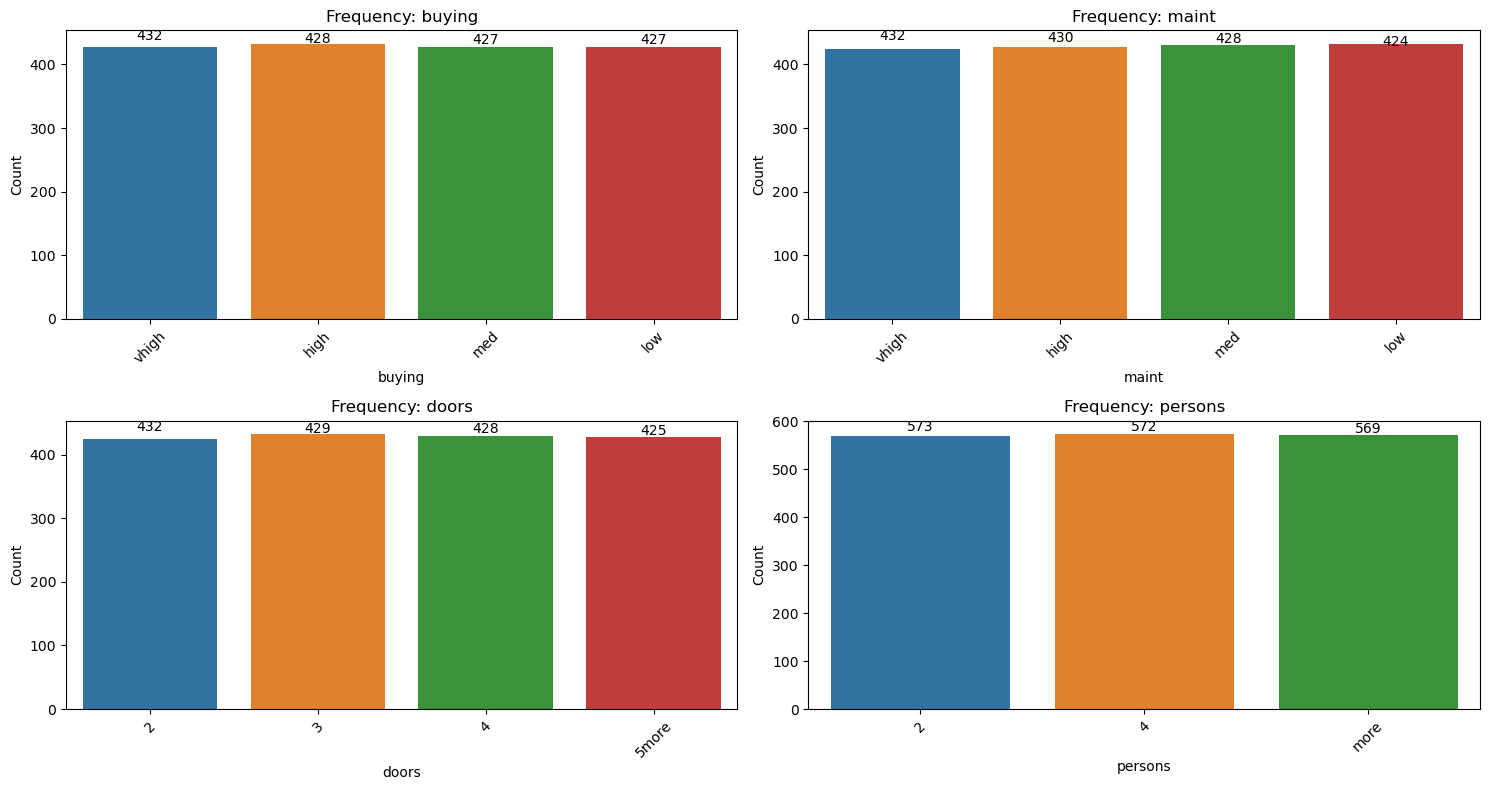

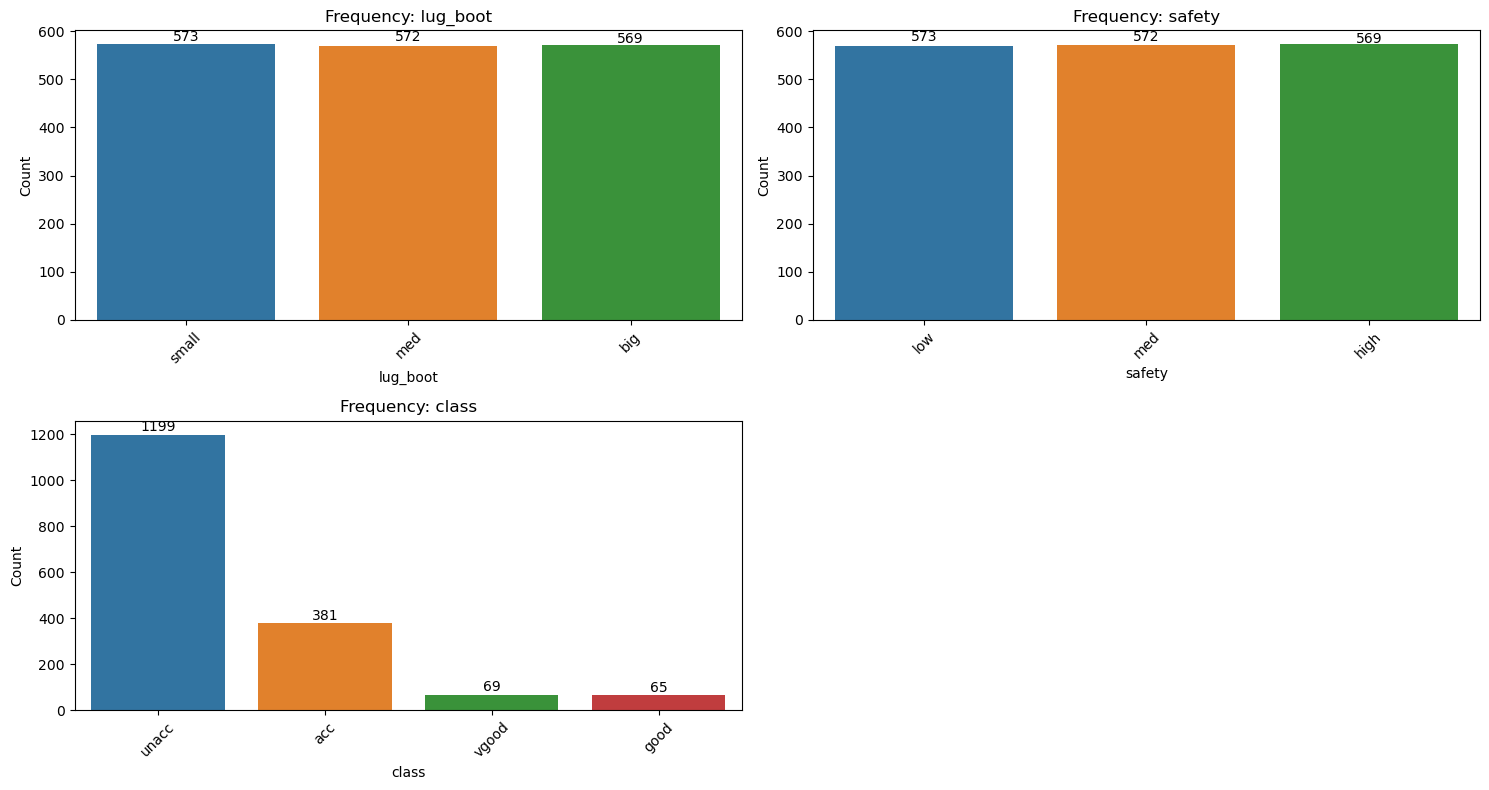

In [12]:
def plot_barplots(dataframe, nrow, ncolumn):
    num_columns = len(dataframe.columns)
    num_subplots = nrow * ncolumn
    
    for idx, column in enumerate(dataframe.columns):
        if idx % num_subplots == 0:
            plt.figure(figsize=(15, 8))
        
        plt.subplot(nrow, ncolumn, (idx % num_subplots) + 1)
        sns.countplot(data=dataframe, x=column)
        plt.title(f'Frequency: {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        
        value_counts = dataframe[column].value_counts()
        for i, (value, count) in enumerate(value_counts.items()):
            plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)
        
        if (idx + 1) % num_subplots == 0 or idx == num_columns - 1:
            plt.tight_layout()
            plt.show()
        
plot_barplots(df, 2, 2)

# **Configuration Class (CFG) for Data Preprocessing**

The CFG class is a configuration class designed to control various data preprocessing steps in a machine learning pipeline. By modifying the attributes within this class, you can easily customize the data preprocessing techniques applied to your dataset before training a machine learning model. Let's explore the attributes and their meanings in more detail.

**Outlier Handling**

outlier_clipper: If set to True, outliers in the data will be clipped to a specified range.
outlier_remover: If set to True, outliers will be removed from the dataset.
outlier_replacer: If set to True, outliers will be replaced with a central value (e.g., mean or median).

**Encoding Techniques**

one_hot_encoder: If set to True, categorical variables will be one-hot encoded.
label_encoder: If set to True, categorical variables will be label encoded.
ordinal_encoder: If set to True, ordinal categorical variables will be encoded.

**Feature Scaling**

min_max_scaler: If set to True, data will be scaled using Min-Max scaling.
robust_scaler: If set to True, data will be scaled using Robust scaling.
standard_scaler: If set to True, data will be scaled using Standard scaling.
How to Use the CFG Class

To utilize the CFG class for data preprocessing, follow these steps:

Modify the attributes within the CFG class according to your preprocessing requirements. For example:

CFG.outlier_clipper = True

CFG.label_encoder = True

CFG.robust_scaler = True

Use the CFG attributes in your data preprocessing pipeline. For instance:

if CFG.outlier_clipper:

Apply outlier clipping codes

if CFG.label_encoder:

Apply label encoding codes

if CFG.robust_scaler:

Apply Robust scaling codes

In [13]:
class CFG:
    outlier_clipper = False
    outlier_remover = False
    outlier_replacer = False
    
    one_hot_encoder = False
    label_encoder = True
    ordinal_encoder = True
    
    min_max_scaler = True
    robust_scaler = False
    standard_scaler = False
    
    random_search = True
    grid_search = False

# **Data Preprocessing: Encoding Categorical Variables**

In this section, we define a DataProcessorEncode class responsible for encoding categorical variables within a given DataFrame. The class offers different encoding techniques based on the provided configuration (cfg).

1. One-Hot Encoding (one_hot_encoder)

The one_hot_encoder method applies one-hot encoding to categorical variables with more than two unique values. It identifies such columns (object_cols) and creates binary columns for each unique category using the pd.get_dummies function. If applicable columns are found, one-hot encoding is applied; otherwise, a warning is issued.

2. Label Encoding (label_encoder)

The label_encoder method applies label encoding to categorical variables with exactly two unique values. It uses the LabelEncoder from scikit-learn to transform binary categorical columns into numerical values (0 and 1). Similar to one-hot encoding, a warning is issued if no applicable columns are found.

3. Ordinal Encoding (ordinal_encoder)

The ordinal_encoder method performs ordinal encoding for all categorical columns. It maps unique category values to incremental integer values, effectively transforming categorical variables into ordinal representations. A dictionary (ordinal_encoder) is created to store the mapping for each categorical column.

After defining these encoding methods, the encode_data function takes a DataFrame as input and applies the specified encoding techniques based on the provided configuration (cfg).

Finally, an instance of the DataProcessorEncode class is created with a configuration object (CFG()), and the encode_data method is called on the input DataFrame df. The encoded DataFrame df is returned and displayed using the .head() method.

In [14]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()>2]
            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")

        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["object","category"]
                           and dataframe[col].nunique()==2]
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    unique_values = sorted(dataframe[col].unique())
                    ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                    dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
df = data_processor_encode.encode_data(df)
df.head()

Ordinal encoding applied.


,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
3,3,3,0,0,1,1,2
5,3,3,0,0,1,0,2
6,3,3,0,0,0,1,2


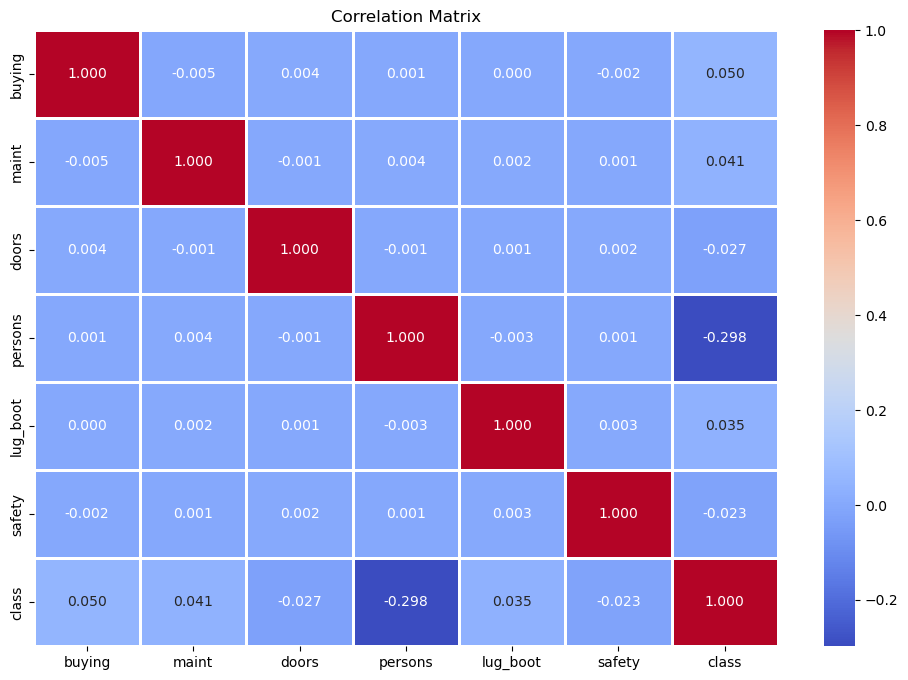

In [15]:
def correlation_matrix(dataframe):
    num_cols = dataframe.select_dtypes(include=[int,float]).columns

    variables = num_cols
    data = dataframe[variables]
    correlation_matrix = data.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=1)
    plt.title('Correlation Matrix')
    
correlation_matrix(df)

# **Data Preprocessing: Feature Scaling**

In this section, we define a DataProcessorScaled class responsible for scaling numerical features within a given DataFrame. The class provides different scaling techniques based on the provided configuration (cfg).

1. Min-Max Scaling (min_max_scaler)

The min_max_scaler method applies Min-Max scaling to numerical columns. It identifies numerical columns (num_cols) and scales their values to the range [0, 1] using the MinMaxScaler from scikit-learn. If applicable numerical columns are found, Min-Max scaling is applied; otherwise, a warning is issued.

2. Standard Scaling (standard_scaler)

The standard_scaler method applies Standard Scaling (z-score normalization) to numerical columns. Similar to Min-Max scaling, it identifies numerical columns and scales their values to have zero mean and unit variance using the StandardScaler from scikit-learn.

3. Robust Scaling (robust_scaler)

The robust_scaler method applies Robust Scaling to numerical columns. This technique is less sensitive to outliers than Min-Max or Standard Scaling. It scales the data using the median and interquartile range. Numerical columns are identified, and their values are scaled using the RobustScaler from scikit-learn.

In [16]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        if self.cfg.min_max_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            num_cols = [col for col in num_cols if col != 'class']            
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe
    
data_processor_scale = DataProcessorScaled(CFG())
df = data_processor_scale.scaled_data(df)
df.head()

Min-Max scaling applied.


,buying,maint,doors,persons,lug_boot,safety,class
0,1.0,1.0,0.0,0.0,1.0,0.5,2
1,1.0,1.0,0.0,0.0,1.0,1.0,2
3,1.0,1.0,0.0,0.0,0.5,0.5,2
5,1.0,1.0,0.0,0.0,0.5,0.0,2
6,1.0,1.0,0.0,0.0,0.0,0.5,2


# **Data Splitting and Creation of Training/Test Sets**

In this section, we showcase the process of splitting your dataset into training and test subsets, a fundamental step for training and evaluating machine learning models. The provided code utilizes the train_test_split function to partition your dataset into two distinct subsets.

**test_size**: This parameter determines the proportion of the dataset that will be allocated to the test subset. In this case, a value of 0.2 has been used, signifying that 20% of the data is allocated to the test subset.

**random_state**: This parameter controls the randomness during the data splitting process. By setting this value, you can reproduce the same data split when you run the process again. Here, it is set to 42.

In [17]:
test_size = 0.2
random_state = 42
X = df.drop(columns=['class'])
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# **Model Training, Evaluation, and Result Visualization**

In this section, a function named model is defined to train, evaluate, and visualize the performance of a set of machine learning models. Additionally, another function named model_to_dataframe is provided to summarize the results of the model evaluations in a structured DataFrame.

1. plot_confusion_matrix Function

This function, plot_confusion_matrix, takes true labels (y_true), predicted labels (y_pred), the model's name (model_name), and an axis (ax) to create and display a confusion matrix heatmap. The confusion matrix visually represents the distribution of correct and incorrect predictions for each class.

2. model Function

The model function performs the following steps for each model specified in the models dictionary:

Fits the model using the resampled training data (X_train_resampled and y_train_resampled).
Generates predictions (y_pred) on the test set.
Calculates accuracy, precision, recall, and F1 score using various scoring metrics.
Stores the evaluation metrics in the results dictionary.
Calls the plot_confusion_matrix function to visualize the confusion matrix for the current model.
Finally, it displays a grid of confusion matrix heatmaps for each model using matplotlib and returns the results dictionary containing the evaluation metrics.

3. model_to_dataframe Function

This function, model_to_dataframe, utilizes the model function to evaluate the models' performance and converts the resulting results dictionary into a structured DataFrame. The DataFrame includes columns for 'Accuracy', 'Precision', 'Recall', and 'F1 Score' for each model.

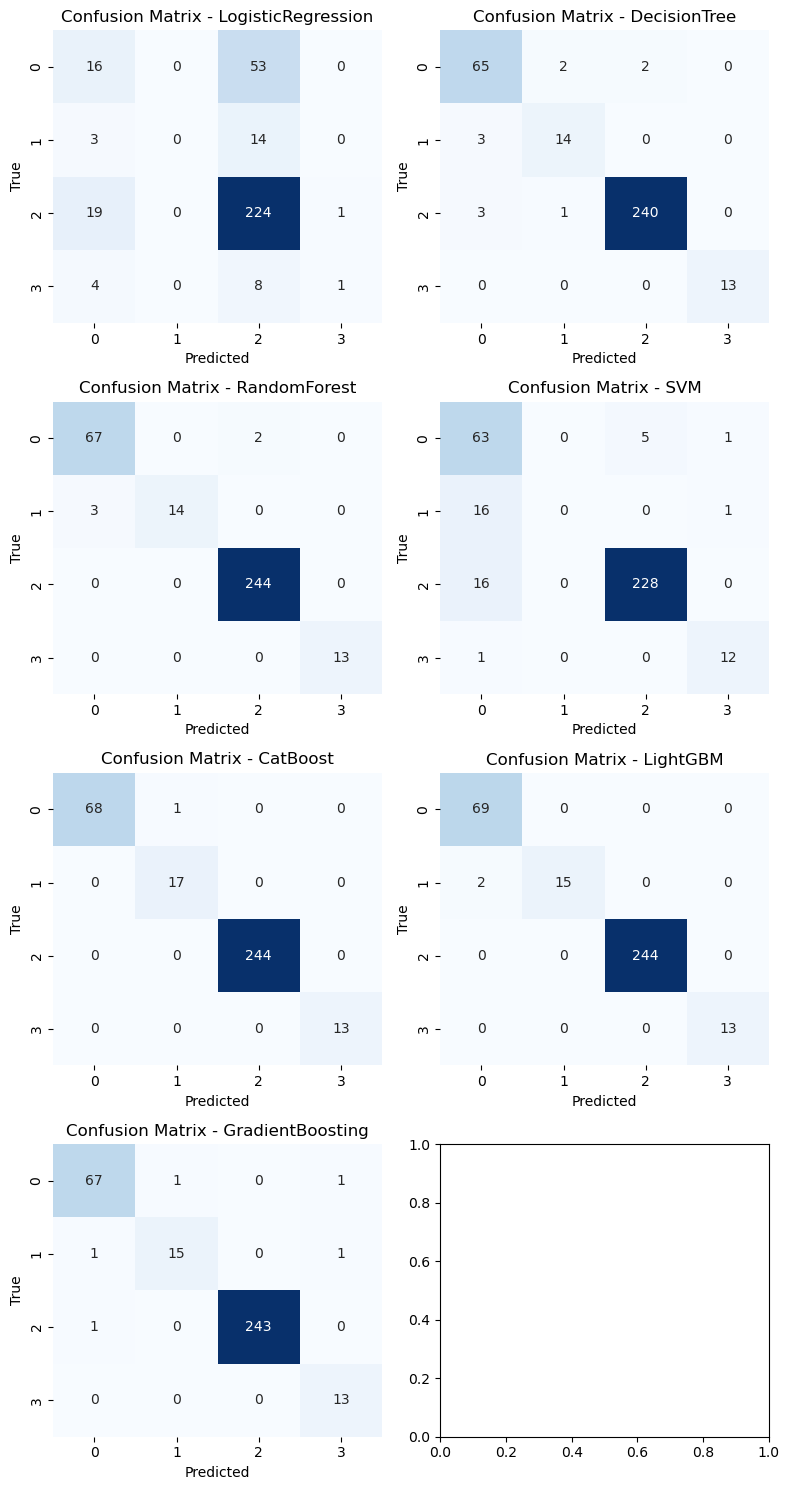

,Accuracy,Precision,Recall,F1 Score
CatBoost,0.997085,0.997247,0.997085,0.997116
LightGBM,0.994169,0.994333,0.994169,0.994029
RandomForest,0.985423,0.985595,0.985423,0.985064
GradientBoosting,0.985423,0.986018,0.985423,0.985495
DecisionTree,0.967930,0.968375,0.967930,0.968102
SVM,0.883382,0.860607,0.883382,0.867360
LogisticRegression,0.702624,0.628518,0.702624,0.649961


In [18]:
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {model_name}')

def model(df, test_size=0.2, random_state=42):
    
    models = {
        'LogisticRegression': LogisticRegression(max_iter=5000, solver='lbfgs'),
        'DecisionTree': tree.DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'CatBoost': CatBoostClassifier(verbose=False),
        'LightGBM': lgb.LGBMClassifier(verbose=-1),
        'GradientBoosting': GradientBoostingClassifier()
    }

    results = {}
    
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 15))
    axes = axes.flatten()
    results = {}

    for i, (model_name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

        plot_confusion_matrix(y_test, y_pred, model_name, axes[i])

    plt.tight_layout()
    plt.show()
    
    return results

def model_to_dataframe(df, test_size=0.2, random_state=42):
    results = model(df, test_size, random_state)
    result_df = pd.DataFrame(results).T
    result_df = result_df.sort_values(by='Accuracy', ascending=False)
    return result_df

model_to_dataframe(df)

# **Hyperparameter Tuning Function**

This function, named hyperparameter_tuning, is designed for performing hyperparameter tuning for a collection of machine learning models. It takes a dictionary of models along with corresponding params (hyperparameter grids), input features X, target variable y, and an optional cv (cross-validation) parameter.

The function iterates through each model specified in the models dictionary and performs hyperparameter tuning if hyperparameters are provided in the params dictionary. For each model, it follows these steps:

If the model doesn't require hyperparameters, it skips tuning for that model and proceeds to the next one.

If the model is an instance of CatBoostClassifier, it sets the verbosity level to 0 to suppress intermediate output during training.

It uses GridSearchCV to perform cross-validated grid search over the specified hyperparameter grid (params[model_name]) for the given model. The cv parameter controls the number of folds in cross-validation, and n_jobs=-1 indicates that computations are parallelized across all available CPU cores.

The best parameters, best score, and best model obtained from the grid search are stored in the best_models dictionary.

The function prints the best parameters and best score for the current model.

In [19]:
def hyperparameter_tuning(models, params, X, y, cv=10):
    best_models = {}
    
    for model_name, model in models.items():
        if model_name not in params:
            print(f"Skipping Hyperparameter Tuning for {model_name} as it doesn't require hyperparameters.")
            continue
        
        print(f"Performing Hyperparameter Tuning for {model_name}...")
        if isinstance(model, CatBoostClassifier):
            model.set_params(verbose=0)
            
        if CFG.random_search:
            search_cv = RandomizedSearchCV(model, params[model_name], cv=cv, n_iter=10, n_jobs=-1)
        elif CFG.grid_search:
            search_cv = GridSearchCV(model, params[model_name], cv=cv, n_jobs=-1)
        else:
            print("Can not found CV optimization variable..")
            continue

        search_cv.fit(X_train, y_train)
        
        best_params = search_cv.best_params_
        best_score = search_cv.best_score_
        
        best_models[model_name] = {
            'Best Parameters': best_params,
            'Best Score': best_score,
        }
        
        print(f"{model_name} - Best Parameters:", best_params)
        print(f"{model_name} - Best Score:", best_score)
        print("\n")
    
    return best_models


In [20]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=5000, solver='lbfgs'),
    'DecisionTree': tree.DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'CatBoost': CatBoostClassifier(verbose=False),
    'LightGBM': lgb.LGBMClassifier(verbose=-1),
    'GradientBoosting': GradientBoostingClassifier()
    }

params = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2', 'elasticnet'],
        'C': np.arange(1,11),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500, 1000]
    },
    
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 3, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    
    'RandomForest': {
        'n_estimators': [100, 200, 300, 500, 1000],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    
    'SVM': {
        'C': np.arange(1,11),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5],
        'gamma': ['scale', 'auto']
    },
    
    'CatBoost': {
        'iterations': [100, 200, 300, 500],
        'learning_rate': [0.01,0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    },
    
    'LightGBM': {
        'num_leaves': [20, 30, 40, 50],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01,0.05, 0.1],
        'verbose': [-1]
    },
    
    'GradientBoosting': {
        'n_estimators': [100, 200, 300, 500],
        'loss': ['equivalent', 'log_loss'],
        'learning_rate': [0.01,0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
}


best_models = hyperparameter_tuning(models, params, X_train, y_train)

def results_to_dataframe(best_models):
    results = []

    for model_name, model_info in best_models.items():
        params = model_info['Best Parameters']
        score = model_info['Best Score'],

        results.append({
            'Model': model_name,
            'Best Parameters': params,
            'Best Score': score
        })

    return pd.DataFrame(results)

result_df = results_to_dataframe(best_models)
result_df.sort_values(by='Best Score', ascending=False)

Performing Hyperparameter Tuning for LogisticRegression...
LogisticRegression - Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 200, 'C': 2}
LogisticRegression - Best Score: 0.6863641172114672


Performing Hyperparameter Tuning for DecisionTree...
DecisionTree - Best Parameters: {'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'criterion': 'gini'}
DecisionTree - Best Score: 0.97957791177404


Performing Hyperparameter Tuning for RandomForest...
RandomForest - Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy'}
RandomForest - Best Score: 0.9781233470855814


Performing Hyperparameter Tuning for SVM...
SVM - Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'C': 4}
SVM - Best Score: 0.9598910398815192


Performing Hyperparameter Tuning for CatBoost...
CatBoost - Best Parameters: {'learning_rate': 0.05, 'l2_leaf_reg'

,Model,Best Parameters,Best Score
6,GradientBoosting,"{'subsample': 1.0, 'n_estimators': 300, 'max_d...","(0.997080291970803,)"
5,LightGBM,"{'verbose': -1, 'num_leaves': 50, 'max_depth':...","(0.9919708029197081,)"
4,CatBoost,"{'learning_rate': 0.05, 'l2_leaf_reg': 1, 'ite...","(0.9905215275573893,)"
1,DecisionTree,"{'splitter': 'best', 'min_samples_split': 2, '...","(0.97957791177404,)"
2,RandomForest,"{'n_estimators': 200, 'min_samples_split': 2, ...","(0.9781233470855814,)"
3,SVM,"{'kernel': 'rbf', 'gamma': 'scale', 'degree': ...","(0.9598910398815192,)"
0,LogisticRegression,"{'solver': 'liblinear', 'penalty': 'l1', 'max_...","(0.6863641172114672,)"


# **Summary of Feature Importance Visualization**

The function plot_feature_importance is utilized to visualize the importance of features in a machine learning model.

The function accepts a trained model object, a list of feature names, and an optional parameter top_n to specify the number of top features to display.

The function calculates the feature importances from the model and arranges them in descending order.

If top_n is specified, the function selects the top features based on importance scores and their corresponding feature names.

A bar plot is generated using Seaborn's barplot, where the x-axis represents feature importance scores, and the y-axis represents the feature names.

The color palette 'viridis' is used for a visually appealing representation.

The plot is labeled with axes and a title indicating the number of top features displayed.

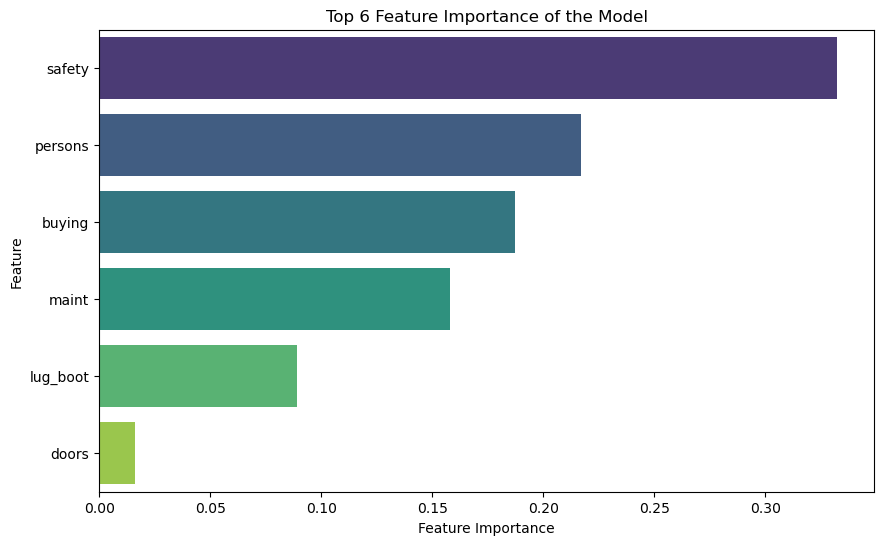

In [21]:
def plot_feature_importance(model, feature_names, top_n=None):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        raise ValueError("Feature importance not available for this model.")
    
    if top_n is not None:
        indices = np.argsort(importances)[::-1]
        top_indices = indices[:top_n]
        top_importances = importances[top_indices]
        top_feature_names = np.array(feature_names)[top_indices]
    else:
        top_importances = importances
        top_feature_names = np.array(feature_names)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importances, y=top_feature_names, palette='viridis')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top {} Feature Importance of the Model'.format(len(top_feature_names)))
    plt.show()

model = GradientBoostingClassifier(subsample = 1.0, n_estimators = 100, max_depth = 5, 
                                   loss = 'log_loss', learning_rate = 0.1)
model.fit(X_train, y_train)

plot_feature_importance(model, X.columns, top_n=len(X.columns))

# **Summary of Model Training and Saving**

A dataset X is created by excluding the 'class' column, and the target variable y is created by selecting only the 'class' column.

The GradientBoostingClassifier model is initialized with specified hyperparameters.

The model is trained using the fit method with the dataset X and the target variable y.

The joblib.dump function is utilized to save the trained model as a binary file named 'best_model.pkl'.

In [22]:
import joblib

X = df.drop(columns=['class'])
y = df['class']

best_model = GradientBoostingClassifier(subsample = 1.0, n_estimators = 100, max_depth = 5, 
                                   loss = 'log_loss', learning_rate = 0.1)
best_model.fit(X, y)

joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']